### Problem Statement ###
The goal of this project was to implement a deep-learning algorithm that classifies electrocardiogram (ECG) recordings from a single-channel handheld ECG device into four distinct categories: normal sinus rhythm (N), atrial fibrillation (A), other rhythm (O), or too noisy to be classified (~). This model was guided by the paper *[Convolutional Recurrent Neural Networks for Electrocardiogram Classification](https://arxiv.org/abs/1710.06122)* by *Zihlmann et al.* which was published following the authors' contribution to the [2017 PhysioNet/Computing in Cardiology (CinC) Challenge](https://physionet.org/challenge/2017/). 

Atrial fibrillation (AF) is a common heart rhythm disorder, affecting more than 2.7 million Americans. This arrhythmia is associated with significant morbidity, carrying a 4- to 5-fold increased risk for ischemic stroke. AF is often silent, with patients occasionally presenting with stroke as the first manifestation of the arrhythmia. Other patients have troubling symptoms such as palpitations or dizziness, but traditional monitoring has been unable to define an arrhythmia. Despite the importance of the problem, AF detection is difficult because it may be episodic. Therefore, periodic sampling of heart rate and rhythm could be helpful to establish a diagnosis in these conditions. The [AliveCor](https://www.alivetec.com/pages/alivecor-heart-monitor) mobile ECG device is capable of recording a single-lead equivalent ECG when each of the two electrodes are held in each hand. A total of 12,186 ECG recordings were generously donated by *AliveCor* for the 2017 PhysioNet/CinC challenge.
![AliveCor KardiaMobile ECG](AliveCorimage.jpg)

#### Files in the project package ####
The project package contains the following files:

* physionet_readme.ipynb: this README.md file with working code
* CNNforECGclassification_model.ipynb: complete model which runs with the small data set
* physio_small.h5: small version of the dataset with 500 samples to run the model notebook
* REFERENCE-v3.csv: labels
* physionet_processing.py: data processing functions
* physionet_generator.py: batch generator class

### Description of the data set ###
The training and test sets contain 8,528 and 3,658 single-lead ECG recordings, respectively, lasting from 9 s to 61 s. The training set can be downloded [here](https://www.physionet.org/challenge/2017/). The test set has not been made available to the public and will remain private for the purpose of scoring for the duration of the Challenge and for some period afterwards to enable follow-up work. The data are provided as EFDB-compliant Matlab V4 files (each including a .mat file containing the ECG and a .hea file containing the waveform information). A detailed description of the data set and how it was generated can be found in the paper *[AF Classification from a Short Single Lead ECG Recording: the PhysioMet/Computing in Cardiology Challenge 2017](https://physionet.org/challenge/2017/Clifford_et-al-challenge_2017_CinC_paper.pdf)*. I have converted the data set into a single hdf5 file which can be downloaded here [here](https://s3.us-east-2.amazonaws.com/cscie89/physio.h5). A smaller version with fewer samples is included in this project submission to demonstrate the training of the model.

In [3]:
df = pd.read_csv(label_file, header = None, names = ['name', 'label'])
df_stat = df.groupby('label').agg('count').reset_index()
df_stat.columns = ['label', 'recordings']
df_stat = df_stat.assign(percent = (100 * np.around(df_stat.recordings/df.shape[0], 2)).astype(np.int))
print(df_stat)
df_set = list(df.label.unique())

  label  recordings  percent
0     A         758        9
1     N        5076       60
2     O        2415       28
3     ~         279        3


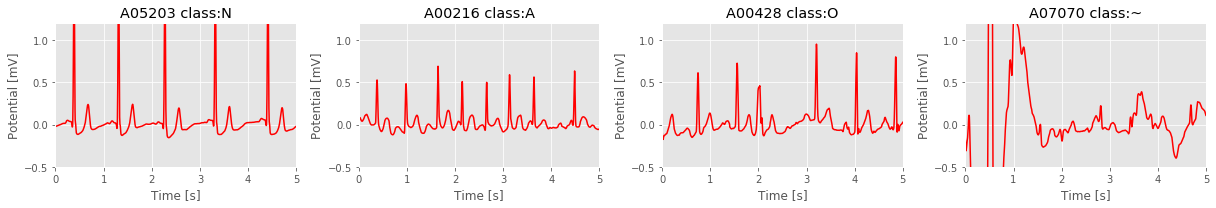

In [4]:
from physionet_processing import fetch_h5data
np.random.seed(148)

# Open large hdf5 file (download https://s3.us-east-2.amazonaws.com/cscie89/physio.h5)
h5file =  h5py.File(hd_file_large, 'r')

# Get a list of dataset names 
dataset_list = list(h5file.keys())

def get_sample():
    # Pick one ECG randomly from each class 
    fid_list = [np.random.choice(df[df.label == label].name.values, 1)[0] for label in df_set]
    return fid_list

name_list = get_sample()
slen = 1500
idx_list = [dataset_list.index(name) for name in name_list]
data = fetch_h5data(h5file, idx_list, sequence_length = slen)
time = np.arange(0, slen)/300

fig, ax = plt.subplots(1, len(idx_list), figsize = (17, 3))

for i, ax1 in enumerate(ax):
    
    ax1.plot(time, data[i], color = 'r')
    ax1.set(xlim = [0, 5], xticks = np.arange(0, 5.5, 1),
            ylim = [-0.5, 1.2], yticks = np.arange(-0.5, 1.2, 0.5),
            xlabel = 'Time [s]', ylabel = 'Potential [mV]')
    ax1.set_title(name_list[i] + ' class:' + df_set[i])


plt.tight_layout()
plt.show()    
fig.savefig('physionet_classes.png', bbox_inches = 'tight', dpi = 150)

### Hardware and software ###
The model was developed on a laptop with a conventional Intel Core i7 CPU and Windows 10. Training was carried out on an Amazon AWS p3.2xlarge instance which uses a Tesla V100 GPU running *Deep Learning AMI with Source Code Ubuntu v5.0 (ami-173bd86a)*. 

All code was written in python 3.4 using the *[Anaconda](https://www.anaconda.com/)* 4.5.1 environment. *Keras* 2.1.5 was used with *TensorFlow* 1.5.0 as the back end. Detailed descriptions for installing *Anaconda Python*, *TensorFlow* and Keras can be found on these websites: 

* [Anaconda distribution](https://www.anaconda.com/download/)
* [TensorFlow](https://www.tensorflow.org/install/)
* [Keras](https://keras.io/)

Other required packages are:

* numpy, pandas, scikit-learn, matplotlib, h5py

### Data set conversion and preprocessing ###
To prepare the data set for convenient access, all matlab files were assembled into a single compressed hdf5 file using the custim Matlab script *mat2hdf5.m*. The data can be viewed using the free hdf5 viewer, which is available for downloaded from the [HDF Support Group](https://support.hdfgroup.org/products/java/hdfview/). A screenshot of the hdf5viewer is shown below. ![HDFView offers convenient access to an hdf5 file](hdf5viewer3.png)

For each group of data in the hdf5 file representing a single ECG time series, the following metadata was saved as attribute: 

* baseline voltage in uV 
* bit depth 
* gain 
* sampling frequency
* measurement units

It is important to know if those parameters are constant across the entire data set and if they have to be taken into account during preprocessing. For example, differences in the baseline voltage or gain would require scaling of the amplitudes. Simliarly, different sampling rates would require, re-sampling to ensure that all feature are represented at the same time scale. I therefore tested if these parameters are the same for all ECGs so that they can be safely ignored. 

Unique sampling rates in dataset: [300.0]
Unique gain settings in dataset: [1000.0]
Unique baseline settings: [0.0]
Sequence lengths [min, max]: [2714, 18286]
Recording times in seconds [min, max]: [9.047, 60.953]


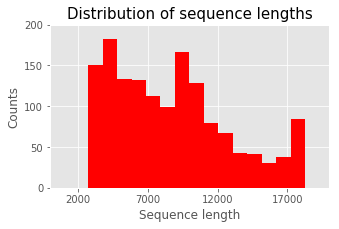

In [5]:
from physionet_processing import special_parameters

sequence_lengths, sampling_rates, recording_times, baselines, gains = special_parameters(h5file)
sequence_length_min, sequence_length_max = np.min(sequence_lengths), np.max(sequence_lengths)
recording_time_min, recording_time_max = np.min(recording_times), np.max(recording_times)

print('Unique sampling rates in dataset:', sampling_rates)
print('Unique gain settings in dataset:', gains)
print('Unique baseline settings:', baselines)
print('Sequence lengths [min, max]:', [sequence_length_min, sequence_length_max])
print('Recording times in seconds [min, max]: [%.3f, %.3f]' %(recording_time_min, recording_time_max))

# Plot a histogram of sequence lengths
fig = plt.figure(figsize = (5, 3))
f = sns.distplot(list(sequence_lengths), norm_hist = False, kde = False, color = 'red', hist_kws=dict(alpha=1))
f.set(xlabel = 'Sequence length', xlim = [0, 20000], xticks = np.arange(2000, 20000, 5000))
f.set(ylabel = 'Counts', ylim = [0, 200], yticks = np.arange(0, 250, 50))
plt.title('Distribution of sequence lengths', fontsize=15)
plt.show()
fig.savefig('physionet_sequenceLenHist.png', bbox_inches = 'tight', dpi = 150)

# Based on this, we can set some parameters that we will use in the future
fs = sampling_rates[0] # universal sampling rate
sequence_length = sequence_length_max # will use the maximum sequence length

This result shows that sampling the rate, the gain and the baseline settings are the same for all ECG time series. This means that these variables do not need to be attached as attributes to the individual ECGs. Removing these attributes from the hdf5 files and applying a stronger compression level greatly reduced the file sizes.
For demonstration of the model, I also created an hdf5 file which is attached to this project. All dataset files can be downloaded by clicking on the links below.

* [physio.h5 (1.3 GB) original uncompressed dataset with metadata](https://s3.us-east-2.amazonaws.com/cscie89/physio.h5)
* [physio2.h5 (200 MB) compressed dataset without metadata](https://s3.us-east-2.amazonaws.com/cscie89/physio2.h5)
* [physio_small.h5 (20 MB) small compressed datset, 800 ECGs for demonstration puposes](https://s3.us-east-2.amazonaws.com/cscie89/physio_small.h5)

### ECG time series processing for deep learning algorithms ###
#### 1. Zero padding to extend sequences ####
Convolutional neural networks require input data to be of the same size. However, because the recording lengths that varied between 3s and 20s in the data set, ECGs were padded with zeros to create sequences of consistent lengths.

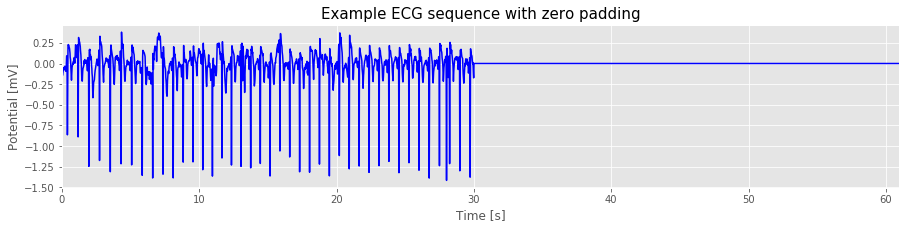

In [6]:
from physionet_processing import extend_ts

ts = h5file[dataset_list[15]]['ecgdata'][:, 0] # Fetch one time series from the hdf5 file
#ts = h5file[list(h5file.keys())[20]]['ecgdata']
ts_extended = extend_ts(ts, length = sequence_length_max) # Extend it to the maximum length
time = np.arange(0, len(ts_extended))/fs

# Plot the the extended time series
fig, ax1 = plt.subplots(figsize = (15, 3))
ax1.plot(time, ts_extended, 'b')
ax1.set(xlabel = 'Time [s]', xlim = [0, time[-1]], xticks = np.arange(0, time[-1]+5, 10))
ax1.set(ylabel = 'Potential [mV]')
plt.title('Example ECG sequence with zero padding', fontsize = 15)
fig.savefig('physionet_ECG_padding.png', bbox_inches = 'tight', dpi = 150)
plt.show()

#### 2. Time series conversion into spectrograms ####
Electrocardiograms are representations of the periodic cardiac cycle. They contain useful information both in the time and the frequency domain. We can extract frequency information by applying a Fourier transform and normalizing the frequency contributions to obtain the power spectrum of the ECG shown above.

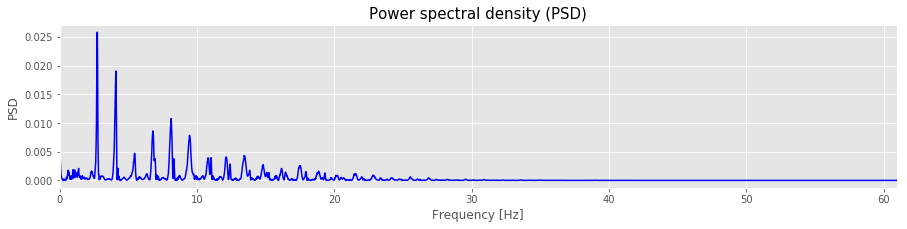

In [7]:
from scipy import signal
f1, PSD = signal.periodogram(ts_extended, fs, 'flattop', scaling = 'density')
fig, ax1 = plt.subplots(figsize = (15, 3))
ax1.plot(f1, PSD, 'b')
ax1.set(xlabel = 'Frequency [Hz]', xlim = [0, time[-1]], xticks = np.arange(0, time[-1]+5, 10))
ax1.set(ylabel = 'PSD')
plt.title('Power spectral density (PSD)', fontsize = 15)
fig.savefig('physionet_ECG_PSD.png', bbox_inches = 'tight', dpi = 150)
plt.show()

To preserve both time and frequeny content of the signal, we can combine the PDS and the time series. A spectrogram returns the time-dependent fourier transform for a sequence computed using a sliding window. This form of the Fourier transform, also known as the short-time Fourier transform (STFT), has numerous applications in speech, sonar, and radar processing. The spectrogram of a sequence is the magnitude of the time-dependent Fourier transform versus time. To optimize the dynamic range of frequency, it is also useful to apply a logarithmic transform. In fact, other reports showed that the logarithmic transform considerably increases the classification accuracy. Here is an illustration of the effect of the logarithmic transform.

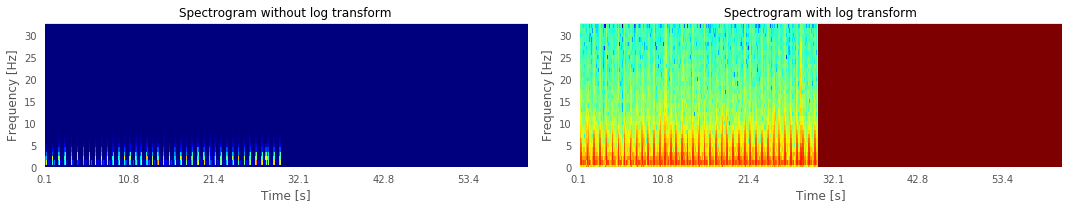

In [8]:
from physionet_processing import spectrogram

# Convert ECG into spectrograms without and with log transform
Sx = spectrogram(np.expand_dims(ts_extended, axis = 0), log_spectrogram = False)[2]
Sx_log = spectrogram(np.expand_dims(ts_extended, axis = 0), log_spectrogram = True)[2]

# Get the frequency and time axes
f, t, _ = spectrogram(np.expand_dims(ts_extended, axis = 0), log_spectrogram = False) 

# Plot the spectrograms as images
im_list = [Sx[0], Sx_log[0]]
im_title = ['Spectrogram without log transform', 'Spectrogram with log transform']
fig, ax_list = plt.subplots(1, 2, figsize = (15, 3))

for i, ax in enumerate(ax_list):
    
    ax.imshow(np.transpose(im_list[i]), aspect = 'auto', cmap = 'jet')
    ax.grid(False)
    ax.invert_yaxis()
    ax.set_title(im_title[i], fontsize = 12)
    ax.set(ylim = [0, im_list[i].shape[1]], yticks = np.arange(0, im_list[i].shape[1] + 1, 5))
    ax.set(xlabel = 'Time [s]', ylabel = 'Frequency [Hz]')
    
    # Replace axis labels with time from t array
    xticks_array = np.arange(0, im_list[i].shape[0] + 1, 100)
    ax.set(xlim = [0, im_list[i].shape[0]], xticks = xticks_array)
    labels_new = [str(np.around(t[label], decimals = 1)) for label in xticks_array]
    ax.set_xticklabels(labels_new)
    ax.tick_params(axis = 'x',
                   which = 'both',
                   bottom = 'off')
    
    ax.tick_params(axis = 'y',
                   which = 'both',
                   left = 'off')

plt.tight_layout()
plt.show()
fig.savefig('physionet_ECG_spectrogram.png', bbox_inches = 'tight', dpi = 150)

#### 3. Data augmentation to reduce overfitting ####
It is expected that severe overfitting will occur due to the large number of parameters in the network architecture. It was demonstrated that data augmentation can act as a regularizer to prevent overfitting in neural networks, and thus improve the generalization of the model. Here, I have reproduced the two data augmentation techniques that were demonstrated in the paper by *Zihlmann et al [Convolutional Recurrent Neural Networks for Electrocardiogram Classification](https://arxiv.org/abs/1710.06122)*: Dropout bursts are created by selecting time instants uniformly at random and setting the ECG signal values in a 50ms vicinity of those time instants to zero. Dropout burst therefore model short periods of weak signal due to, e.g., bad contact of ECG leads. Assuming a heart rate of 80 beats per minute for all training ECG signals, random resampling emulates a broader range of heart rates by uniformly resampling the ECG signals such that the heart rate of the resampled signal is uniformly distributed on the interval [60, 120] bpm. These emulated heart rates may be unrealistically high or low due to the assumption of an 80bpm heart rate independently of the signal.

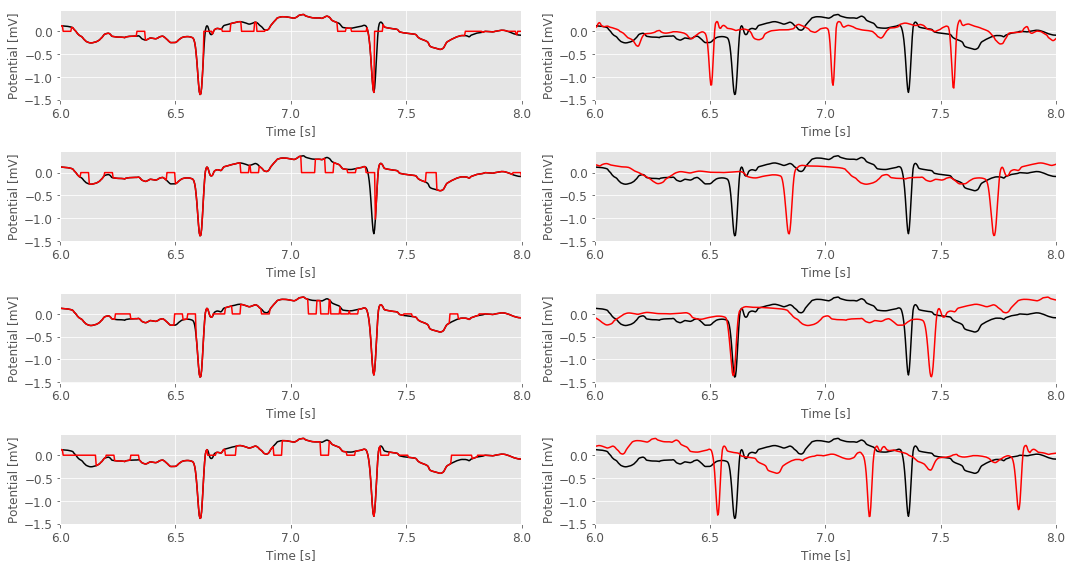

In [9]:
from physionet_processing import zero_filter, random_resample

data_zero = [] # collect the zero burst data here
data_resampled = [] # list for resampled data
runs = 4

for i in range(runs):
    data_zero.append(zero_filter(np.expand_dims(ts_extended, axis = 0), threshold = 2, depth = 10)[0])
    data_resampled.append(random_resample(np.expand_dims(ts_extended, axis = 0))[0])

# Plot the result
fig, axarr = plt.subplots(runs, 2, figsize = (15, 8))
x_lim = [6, 8] # zoom in on x axis
x_ticks = np.arange(x_lim[0], x_lim[1] + 0.5, 0.5) # ticks
x_label = 'Time [s]'
y_label = 'Potential [mV]'

for row in range(runs):
    
    # Plot the dropout burst data
    ax = axarr[row, 0]
    ax.plot(time, ts_extended, 'k')
    ax.plot(time, data_zero[row], 'r')
    ax.set(xlim = x_lim, xticks = x_ticks)
    ax.set(xlabel = x_label, ylabel = y_label)
    
    # Plot the resampling data
    ax = axarr[row, 1]
    ax.plot(time, ts_extended, 'k')
    ax.plot(time, data_resampled[row], 'r')
    ax.set(xlim = x_lim, xticks = x_ticks)
    ax.set(xlabel = x_label, ylabel = y_label)
    
for ax in np.ndarray.flatten(axarr):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

plt.tight_layout()
#plt.suptitle('Data augmentation: dropout bursts and random resampling', fontsize = 15)
plt.show()
fig.savefig('physionet_augmentation.png', bbox_inches = 'tight', dpi = 150)

### Custom batch generator to feed spectrograms into a Keras model ###
CPU memory is usually limited (especially on my laptop that I am using to write this report) and main memory should therefore be used wisely for manipulating and processing, rather than holding entire data sets. This becomes an abolute necessity when data sets are so large that they won't even fit into memory. Keras comes with several batch generators for images that even provide augmentation, but they do not work with ECGs stored in an hdf5 file.
Here, I am demonstrating how a custom batch generator could be used to feed any data types (here spectrograms) from any source (here hdf5 database) into a Keras model. This batch generator is actually a modified version of a generator class that has been described in a tutorial by Shervine Amidi, a graduate student at Stanford University. Here, only the modifications for the ECG data are described. For more details please see the original [tutorial](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html).  
What's really great here is the fact that this implementation enables the use of the multiprocessing argument of *fit_generator*, where the number of threads specified in *n_workers* are those that generate batches in parallel. A high enough number of workers assures that CPU computations are efficiently managed, i.e. that the bottleneck is indeed the neural network's forward and backward operations on the GPU (and not data generation).

In [10]:
# The initialization function of the generator class defines the parameters 
# that are needed for ECG processing
'Generates data for Keras'
def __init__(self, h5file, list_IDs, labels, batch_size = 32, dim = (178, 33), 
             nperseg = 64, noverlap = 32,
             n_channels=1, sequence_length = 5736,
             n_classes = 4, shuffle = True, augment = False):
    
    'Initialization'
    self.h5file = h5file
    self.list_IDs = list_IDs
    self.labels = labels
    self.batch_size = batch_size
    self.dim = dim
    self.nperseg = nperseg
    self.noverlap = noverlap
    self.n_channels = n_channels
    self.sequence_length = sequence_length
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.augment = augment
    self.on_epoch_end()

The parameters required for generating batches of ECGs are:
- h5file: hdf5 object generated by h5file =  h5py.File(hd_file, 'r')
- list_IDs: list of ECG ids which are the filename of the original matlab files
- batch_size
- dim: dimension (time steps, frequencies) of the spectrograms
- nperseg: width of the hanning window used for the spectrogram
- noverlap: spectrogram hanning window overlap
- n_channels: number of 'color' channels, here = 1
- sequence length: padded length of each ECG, usually the maximum length of all ECGs in the data set
- n_classes: here = 4
- shuffle: when True, the order in which examples are fed is shuffled. Makes the model more robust.
- augment: applies data augmentation, here dropout bursts and random resampling as described above

The main adaptation to the tutorial is the __data_generation__ function. During data generation, this code reads the NumPy ECG array of each example from its corresponding file in the hdf file. Since this code is multicore-friendly, note that you can do more complex operations instead (e.g. computations from source files) without worrying that data generation becomes a bottleneck in the training process.

Also, please note that Keras' keras.utils.to_categorical function was used to convert the numerical labels stored in y to a binary form.

In [11]:
def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype = float)
        y = np.empty((self.batch_size), dtype = int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            data = extend_ts(self.h5file[ID]['ecgdata'][:, 0], self.sequence_length)
            data = np.reshape(data, (1, len(data)))
        
            if self.augment:
            
                # dropout bursts
                data = zero_filter(data, threshold = 2, depth = 10)
            
                # random resampling
                data = random_resample(data)
            
            # Generate spectrogram
            data_spectrogram = spectrogram(data, nperseg = self.nperseg, noverlap = self.noverlap)[2]
            
            # Normalize spectrogram
            #data_transformed = norm_float(data_spectrogram, self.data_mean, self.data_std)
            data_norm = (data_spectrogram - np.mean(data_spectrogram))/np.std(data_spectrogram)
        
            X[i,] = np.expand_dims(data_norm, axis = 3)
        
            # Assuming that the dataset names are unique (only 1 per label)
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

Let's run this generator. Before we can do that we actually need to load the labels and encode them. I am using the LabelEncoder class from the Scikit-Learn package here:

In [12]:
from sklearn.preprocessing import LabelEncoder

# Load the labels:
label_df = pd.read_csv(label_file, header = None, names = ['name', 'label'])

# Hot-encode the labels
label_set = list(sorted(label_df.label.unique()))
encoder = LabelEncoder().fit(label_set)
label_set_codings = encoder.transform(label_set)
label_df = label_df.assign(encoded = encoder.transform(label_df.label))

print('Unique labels:', encoder.inverse_transform(label_set_codings))
print('Unique codings:', label_set_codings)
print('Dataset labels:\n', label_df.iloc[100:110,])

Unique labels: ['A' 'N' 'O' '~']
Unique codings: [0 1 2 3]
Dataset labels:
        name label  encoded
100  A00101     A        0
101  A00102     A        0
102  A00103     O        2
103  A00104     N        1
104  A00105     N        1
105  A00106     ~        3
106  A00107     A        0
107  A00108     O        2
108  A00109     N        1
109  A00110     O        2


/home/andy/anaconda3/envs/tf35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Now, the data can be split into training and validation samples. We will store the training and validation IDs corresponding to the names of the original matlab files in the dictionary *partition*. The labels are held in the dictionary *labels*.

In [13]:
from sklearn.model_selection import train_test_split

# Split the IDs in training and validation set
test_split = 0.33
idx = np.arange(label_df.shape[0])
id_train, id_val, _, _ = train_test_split(idx, idx, 
                                         test_size = test_split,
                                         shuffle = True,
                                         random_state = 123)

# Store the ids and labels in dictionaries
partition = {'train': list(label_df.iloc[id_train,].name), 
             'validation': list(label_df.iloc[id_val,].name)}

labels = dict(zip(label_df.name, label_df.encoded))

Now, we can set up the batch generators for training and validation. We first define all of the initialization arguments that the DataGranerator class requires. The spectrogram dimensions depend on the sequence length and the hanning window size which are hyperparameters that we want to be able to change. Therefore, it make sense to determine the dimensions of the spectrograms right before the initialization of the batch generator.

In [14]:
# Parameters needed for the DataGenerator class
# Maximum sequence length
max_length = sequence_length

# Output dimensions
sequence_length = sequence_length_max # Use the maximum sequence length in the data set
spectrogram_nperseg = 64 # Spectrogram hanning window width
spectrogram_noverlap = 32 # Spectrogram hanning window overlap
n_classes = len(label_df.label.unique()) # Number of classes
batch_size = 32

# Use one spectrogram to detemine the image dimensions
Sx_log = spectrogram(np.expand_dims(ts_extended, axis = 0),
                     nperseg = spectrogram_nperseg,
                     noverlap = spectrogram_noverlap,
                     log_spectrogram = True)[2]
dim = Sx_log[0].shape

Now we can initialize the DataGenerator class using the parameters that are defined above.

In [15]:
from physionet_generator import DataGenerator

params = {'batch_size': batch_size,
          'dim': dim,
          'nperseg': spectrogram_nperseg,
          'noverlap': spectrogram_noverlap,
          'n_channels': 1,
          'sequence_length': sequence_length,
          'n_classes': n_classes,
          'shuffle': True}

train_generator = DataGenerator(h5file, partition['train'], labels, augment = True, **params)
val_generator = DataGenerator(h5file, partition['validation'], labels, augment = False, **params)

for i, batch in enumerate(train_generator):
    if i == 1:
        break

X = batch[0]
y = batch[1]

print('X shape:', X.shape)
print('y shape:', y.shape)
print('X type:', np.dtype(X[0,0,0,0]))

X shape: (32, 570, 33, 1)
y shape: (32, 4)
X type: float64


Let's take a look at some images in the batch.

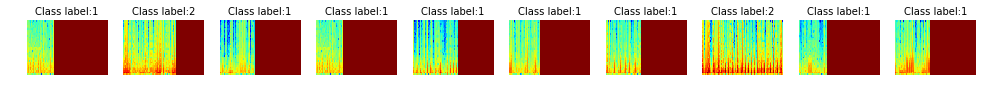

In [16]:
def imshow_batch(X, y, batch_idx):
    
    batch_labels = ['Class label:' + str(np.argmax(y[idx,])) for idx in batch_idx]

    fig, ax = plt.subplots(1, len(batch_idx), figsize = (17, 1))

    for i, idx in enumerate(batch_idx):
    
        ax[i].imshow(X[idx, :, :, 0].transpose(), cmap = 'jet', aspect = 'auto')
        ax[i].grid(False)
        ax[i].axis('off')
        ax[i].invert_yaxis()
        ax[i].set_title(batch_labels[i], fontsize = 10)
    
    plt.show()
        
    return fig

batch_idx = np.random.randint(0, batch_size, size = 10) 
fig = imshow_batch(X, y, batch_idx)
fig.savefig('physionet_Batch.png', bbox_inches = 'tight', dpi = 150)
plt.show()

### Define the Keras model ###
Now that we have batch generator that can feed data into a Keras model, we can define the model itself. Here, I have implemented the CNN architecture that was described by *Zihlmann et al.* *[Convolutional Recurrent Neural Networks for Electrocardiogram Classification](https://arxiv.org/abs/1710.06122)* into a Keras model.

After the spectrogram conversion, six groups  of four convolutional layers (ConvBlock4) are used. In each group, all convolutional layers apply a number of filters over a constant 3 x 3 receptive field. The number of filters is initially set to 32 for the first three convolutional layers, but increases by 32 in the last layer of each convolutional block. This last layer also applies stride 2 while all other layers keep a stride of 1. Using stride 2 for the last layer in each block causes a decrease in size of the output image after each ConvBlock4. Using the default settings for the spectrogram conversion (sequence length = 18286, hanning window size = 64, overlap = 32), the input dimension of the network are 570 x 33 x 1, as shown above for the demonstration of the generator class. Since the convolutional blocks are repeated, it was convenient to write them as a fuction. 

In [17]:
# Convolutional blocks
def conv2d_block(model, depth, layer_filters, filters_growth, 
                 strides_start, strides_end, input_shape, first_layer = False):
    
    ''' Convolutional block. 
    depth: number of convolutional layers in the block (4)
    filters: 2D kernel size (32)
    filters_growth: kernel size increase at the end of block (32)
    first_layer: provide input_shape for first layer'''
    
    # Fixed parameters for convolution
    conv_parms = {'kernel_size': (3, 3),
                  'padding': 'same',
                  'dilation_rate': (1, 1),
                  'activation': None,
                  'data_format': 'channels_last',
                  'kernel_initializer': 'glorot_normal'}

    for l in range(depth):

        if first_layer:
            
            # First layer needs an input_shape 
            model.add(layers.Conv2D(filters = layer_filters,
                                    strides = strides_start,
                                    input_shape = input_shape, **conv_parms))
            first_layer = False
        
        else:
            # All other layers will not need an input_shape parameter
            if l == depth - 1:
                # Last layer in each block is different: adding filters and using stride 2
                layer_filters += filters_growth
                model.add(layers.Conv2D(filters = layer_filters,
                                        strides = strides_end, **conv_parms))
            else:
                model.add(layers.Conv2D(filters = layer_filters,
                                        strides = strides_start, **conv_parms))
        
        # Continue with batch normalization and activation for all layers in the block
        model.add(layers.BatchNormalization(center = True, scale = True))
        model.add(layers.Activation('relu'))
    
    return model

With this, the sequential model can be set up with a few lines of code. First, we need to define the input size and the hyperparameters of the model.

In [18]:
# Input shape
n_channels = 1 # Number of color channgels
input_shape = (*dim, n_channels) # input shape for first layer

# Hyperparameters
filters_start = 32 # Number of convolutional filters
layer_filters = filters_start # Start with these filters
filters_growth = 32 # Filter increase after each convBlock
strides_start = (1, 1) # Strides at the beginning of each convBlock
strides_end = (2, 2) # Strides at the end of each convBlock
depth = 4 # Number of convolutional layers in each convBlock
n_blocks = 6 # Number of ConBlocks

Then the convolutional block can be defined as a sequential model using a few lines of code.

In [19]:
model = Sequential()

for block in range(n_blocks):

    # Provide input only for the first layer
    if block == 0:
        provide_input = True
    else:
        provide_input = False
    
    model = conv2d_block(model, depth,
                         layer_filters,
                         filters_growth,
                         strides_start, strides_end,
                         input_shape,
                         first_layer = provide_input)
    
    # Increase the number of filters after each block
    layer_filters += filters_growth

#### Feature aggregation over time ####
As the convolutional layers process the variable-length input ECGs in full length (padded by zeros), they produce variable-length outputs which have to be aggregated across time before they can be fed into a fully connected layer for classification. In this architecture, temporal aggregation is achieved simply by averaging using a custom lambda layer.

In [20]:
# Define temporal feature avaraging layer
def MeanOverTime():
    lam_layer = layers.Lambda(lambda x: K.mean(x, axis=1), output_shape=lambda s: (1, s[2]))
    return lam_layer

# Reshape to (batch, time steps, filters)
model.add(layers.Reshape((-1, 224)))
model.add(layers.core.Masking(mask_value = 0.0))
model.add(MeanOverTime())

# And a fully connected layer for the output
model.add(layers.Dense(4, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 570, 33, 32)       320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 570, 33, 32)       128       
_________________________________________________________________
activation_1 (Activation)    (None, 570, 33, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 570, 33, 32)       9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 570, 33, 32)       128       
_________________________________________________________________
activation_2 (Activation)    (None, 570, 33, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 570, 33, 32)       9248      
__________

#### Results ####
The model was trained on AWS and the accuracies were saved in the file *history.csv*.

In [21]:
def smoothcols(df, cols):
    
    lfrac = 0.02
    lowess = sm.nonparametric.lowess
    df_sm = df.copy()
    x = df.epoch.values

    # Replace columns with smoothed values
    for c in cols:
        df_sm[c]  = lowess(df[c].values, x, frac = lfrac)[:,1]
        
    return df_sm

In [22]:
# Read history file
history = pd.read_csv('history.csv')

# Make a list of data frames and apply some smoothing
runs = list(reversed(list(history.run.unique()))) # different model conditions (pick reversed order)

cols_to_sm = list(history.columns)[2:] # columns for smoothing

history_list = [] # store the model results
name_list = [] # store the model conditions
for run in runs:
    df = history[history.run == run]
    df_sm = smoothcols(df, cols_to_sm)
    history_list.append(df_sm)
    name_list.append(run)

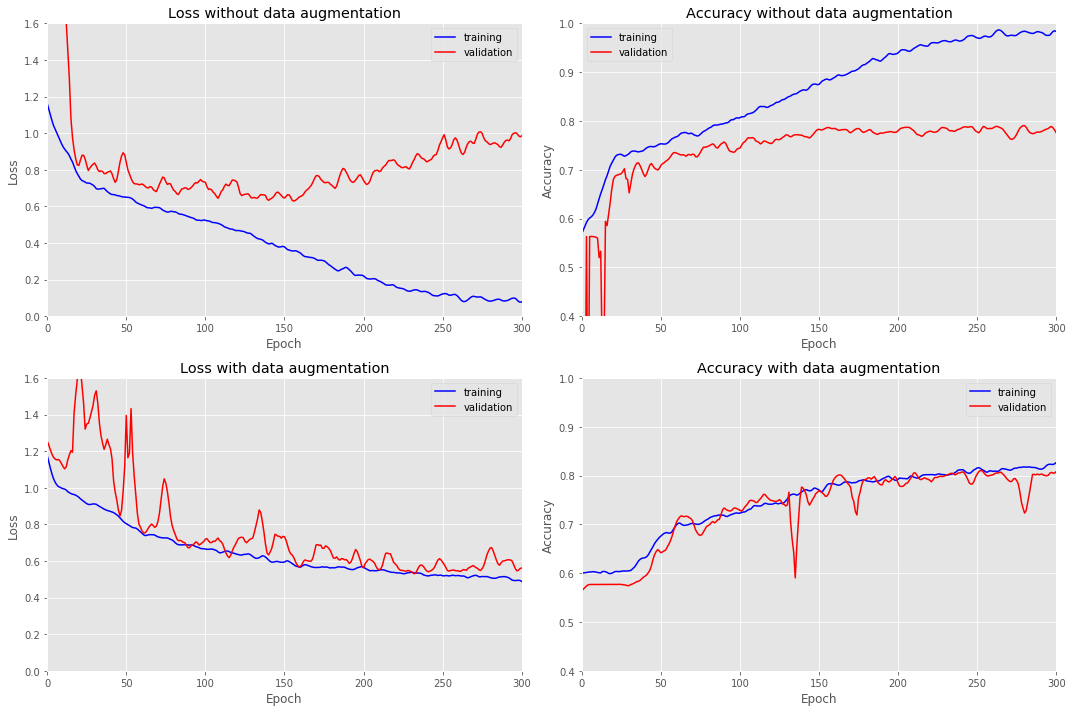

In [23]:
# Plot the history data
fig, axarr = plt.subplots(len(name_list), 2, figsize = (15, 10))

# Model titles
model_title_list = ['without data augmentation', 'with data augmentation']

for row in range(len(history_list)):
    
    ax = axarr[row]
    
    history_list[row].plot(x = 'epoch', y = 'loss', ax = ax[0], label = 'training', color = 'blue')
    history_list[row].plot(x = 'epoch', y = 'val_loss', ax = ax[0], label = 'validation', color = 'red')

    history_list[row].plot(x = 'epoch', y = 'acc', ax = ax[1], label = 'training', color = 'blue')
    history_list[row].plot(x = 'epoch', y = 'val_acc', ax = ax[1], label = 'validation', color = 'red')

    ax[0].set(xlim = [0, 300], xticks = np.arange(0, 350, 50),
              ylim = [0, 1.6], yticks = np.arange(0, 1.8, 0.2),
              xlabel = 'Epoch', ylabel = 'Loss')
    
    ax[0].set_title('Loss ' + model_title_list[row])
    ax[1].set_title('Accuracy ' + model_title_list[row])

    ax[1].set(xlim = [0, 300], xticks = np.arange(0, 350, 50),
              ylim = [0.4, 1.0], yticks = np.arange(0.4, 1.1, 0.1),
              xlabel = 'Epoch', ylabel = 'Accuracy')


plt.tight_layout()
plt.show()
fig.savefig('physionet_history.png', bbox_inches = 'tight', dpi = 150)

This result demonstrates that the model converges very well approaching 80% accuracy for the validation set. The data augmentation technique described here also significantly reduced overfitting. The prominent peaks in the validation accuracy are most likely caused by the unbalanced classes in the data set. This effect might be reduced by adding weight factors to the loss function which would penalize those weights that belong to higher-frequency classes.